# Task 1
Construir un programa que reciba como entrada una imagen cuadrada que represente un laberinto. Deberá dibujar en pantalla la solución al mismo. Deberá considerar las siguientes restricciones:
- Las dimensiones de entrada podrán variar entre ejecuciones (pero siempre será una imagen cuadrada)
- Las áreas blancas representan caminos libres
- Las áreas negras representan paredes sobre las cuales no se puede pasar
- Las áreas verdes representan la meta (goalTest positivos) (pueden ser varios)
- La área roja representa el punto de inicio (solo podrá haber uno)



## Task 1.1 Discretización de la imagen

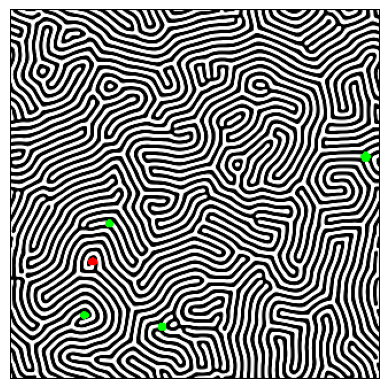

Matriz discretizada:
[[1 1 1 ... 1 1 1]
 [1 0 0 ... 1 0 1]
 [1 0 0 ... 1 0 1]
 ...
 [1 0 1 ... 0 0 1]
 [1 0 1 ... 0 0 1]
 [1 1 1 ... 1 1 1]]
Coordenadas del punto de inicio (rojo): (222, 74)
Coordenadas de los puntos finales (verdes): [(127, 305), (128, 305), (129, 305), (185, 83), (265, 61), (273, 134)]


In [105]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def discretize_image_and_matrix(image_path, pixel_size):
    # Abrir la imagen
    image = Image.open(image_path)
    image = image.convert('RGB')

    # Convertir la imagen a un array numpy
    image_array = np.array(image)
    height, width, _ = image_array.shape

    # Crear una nueva imagen con el tamaño adecuado para agregar el marco negro
    padded_height = height + 2 * pixel_size
    padded_width = width + 2 * pixel_size
    padded_image_array = np.zeros((padded_height, padded_width, 3), dtype=np.uint8)

    # Agregar el marco negro alrededor de la imagen original
    padded_image_array[pixel_size:pixel_size + height, pixel_size:pixel_size + width, :] = image_array

    # Ajustar las dimensiones de la imagen para que sean múltiplos de pixel_size
    new_height = (padded_height // pixel_size) * pixel_size
    new_width = (padded_width // pixel_size) * pixel_size
    padded_image_array = padded_image_array[:new_height, :new_width]

    discretized_height = new_height // pixel_size
    discretized_width = new_width // pixel_size
    discretized_img = np.zeros((discretized_height, discretized_width, 3), dtype=np.uint8)
    discretized_matrix = np.zeros((discretized_height, discretized_width), dtype=np.uint8)

    start_point = None
    end_points = []

    for i in range(0, new_height, pixel_size):
        for j in range(0, new_width, pixel_size):
            region = padded_image_array[i:i + pixel_size, j:j + pixel_size, :]

            # Tomar el color del primer píxel de la región
            pixel_color = region[pixel_size // 2, pixel_size // 2, :]
            discretized_img[i // pixel_size, j // pixel_size, :] = pixel_color

            # Identificar y cambiar píxeles grises a negro por su código RGB
            if np.all(region[:, :, 0] >= 0) and np.all(region[:, :, 0] <= 225):
                pixel_color = [0, 0, 0]  # Cambiar a color negro
            
            # Asignar valor a la matriz discretizada
            if np.all(pixel_color == [0, 0, 0]):
                discretized_matrix[i // pixel_size, j // pixel_size] = 1  # Representa una pared
            elif np.all(pixel_color >= [0, 200, 0]) and np.all(pixel_color <= [50, 255, 50]):
                discretized_matrix[i // pixel_size, j // pixel_size] = 0  # Representa el objetivo (verde)
                end_points.append((i // pixel_size, j // pixel_size))  # Guardar coordenadas del punto final
            elif np.all(pixel_color >= [220, 0, 0]) and np.all(pixel_color <= [255, 50, 50]):
                discretized_matrix[i // pixel_size, j // pixel_size] = 0  # Representa el inicio (rojo)
                start_point = (i // pixel_size, j // pixel_size)  # Guardar coordenadas del punto de inicio

    return discretized_img, discretized_matrix, start_point, end_points

def plot_discretized_image(discretized_img):
    plt.imshow(discretized_img)
    plt.axis('off')
    plt.show()

# Ruta de la imagen y tamaño de píxel deseado
image_path = "Turing.bmp"
# Prueba Lab1.bmp - 15px
# Test bmp - 20px
# Test2.bmp - 15px
# Turing.bmp - 2px
pixel_size = 2  # Ajusta el tamaño del píxel según sea necesario

# Discretizar la imagen y obtener la matriz discretizada
discretized_img, discretized_matrix, start_point, end_points = discretize_image_and_matrix(image_path, pixel_size)

# Visualizar la imagen discretizada
plot_discretized_image(discretized_img)

# Mostrar la matriz discretizada
print("Matriz discretizada:")
print(discretized_matrix)

# Mostrar las coordenadas del punto de inicio (rojo) y de los puntos finales (verdes)
print("Coordenadas del punto de inicio (rojo):", start_point)
print("Coordenadas de los puntos finales (verdes):", end_points)


## Task 1.2 Framework de Problemas
Usar interfaz genérica o abstracta que sirva para representar el framework para definir el problema formal. Se debe utilizar la matriz obtenida del Task 1.1 y con esta deberá deducir las demás funciones del framework. (actions(s), stepCost(s,a,s), etc). Debe utilizar efectivamente los conceptos del paradigma POO. 

In [106]:
from abc import ABC, abstractmethod
from typing import List, Tuple

class SearchAlgorithm(ABC):
    def __init__(self, maze: List[List[int]]):
        self.maze = maze
        self.rows = len(maze)
        self.columns = len(maze[0]) if self.rows > 0 else 0

    # Verifica si un movimiento es válido
    def valid_move(self, position: Tuple[int, int]) -> bool:
        row, column = position
        if 0 <= row < self.rows and 0 <= column < self.columns:
            return self.maze[row][column] == 0  # 0 representa un camino libre
        return False
    
    @abstractmethod
    def actions(self, position: Tuple[int, int]) -> List[Tuple[int, int]]:
        pass
    
    @abstractmethod
    def step_cost(self, current: Tuple[int, int], next: Tuple[int, int]) -> int:
        pass
    
    @abstractmethod
    def search(self, start: Tuple[int, int], goal: Tuple[int, int]) -> List[Tuple[int, int]]:
        pass

## Task 1.3 Graph-Search 
Construir el algoritmo genérico (familia de graphSearch). Este recibirá de parámetro una instancia del framework de problemas. Implemente los siguientes algoritmos:
- Breadth First Search (BFS)
- Depth First Search (DFS)
- A* (escoger dos heurísticas, justificar elección)

## TASK 1.3
### Breadth First Search (BFS)

In [107]:
from collections import deque
from typing import List, Tuple
from abc import ABC, abstractmethod

class SearchAlgorithm(ABC):
    def __init__(self, maze: List[List[int]]):
        self.maze = maze
        self.rows = len(maze)
        self.columns = len(maze[0]) if self.rows > 0 else 0

    def valid_move(self, position : Tuple[int, int]) -> bool:
        row, column = position
        if 0 <= row < self.rows and 0 <= column < self.columns:
            return self.maze[row][column] == 0
        return False
    
    @abstractmethod 
    def actions(self, position: Tuple[int, int]) -> List[Tuple[int, int]]:
        pass
    
    @abstractmethod
    def stepCost(self, current: Tuple[int, int], next: Tuple[int, int]) -> int:
        pass
    
    @abstractmethod
    def search(self, start: Tuple[int, int], goal: Tuple[int, int]) -> List[Tuple[int, int]]:
        pass

class BFS(SearchAlgorithm):
    def __init__(self, maze: List[List[int]]):
        super().__init__(maze)

    def actions(self, position: Tuple[int, int]) -> List[Tuple[int, int]]:
        row, column = position
        possible_moves = [(row+1, column), (row-1, column), (row, column+1), (row, column-1)]
        return [move for move in possible_moves if self.valid_move(move)]

    def stepCost(self, current: Tuple[int, int], next: Tuple[int, int]) -> int:
        return 1

    def search(self, start: Tuple[int, int], goal: Tuple[int, int]) -> List[Tuple[int, int]]:
        frontier = deque([start])
        came_from = {start: None}

        while frontier:
            current = frontier.popleft()
            if current == goal:
                break

            for next_move in self.actions(current):
                if next_move not in came_from:
                    frontier.append(next_move)
                    came_from[next_move] = current

        # Reconstruct path from start to goal
        path = []
        current = goal
        while current != start:
            path.append(current)
            current = came_from[current]
        path.append(start)
        path.reverse()
        return path

In [108]:
#Instancia BFS 
bfs = BFS(discretized_matrix)
#Definir punto de inicio y salida
start = start_point
end = end_points

## TASK 1.3
### Depth First Search (DFS)

In [109]:
class DFSAlgorithm(SearchAlgorithm):
    def __init__(self, maze: List[List[int]]):
        super().__init__(maze)
    
    def actions(self, position: Tuple[int, int]) -> List[Tuple[int, int]]:
        row, col = position
        possible_actions = [(row-1, col), (row+1, col), (row, col-1), (row, col+1)]
        valid_actions = [action for action in possible_actions if self.valid_move(action)]
        return valid_actions
    
    def stepCost(self, current: Tuple[int, int], next: Tuple[int, int]) -> int:
        return 1
    
    def search(self, start: Tuple[int, int], goal: Tuple[int, int], max_depth: int = float('inf')) -> List[Tuple[int, int]]:
        visited = set()
        path = []
        stack = [(start, 0)]

        while stack:
            current, depth = stack.pop()
            if current == goal:
                path.append(current)
                return path

            if depth < max_depth:
                if current not in visited:
                    visited.add(current)
                    path.append(current)

                    possible_actions = self.actions(current)
                    stack.extend([(next_action, depth + 1) for next_action in possible_actions])

        return []
        
dfs_algorithm = DFSAlgorithm(discretized_matrix)

result_path = dfs_algorithm.search(start_point, end_points[0])

## TASK 1.3
### A* 

In [110]:
# Incluir ambas heurísticas aquí
import heapq



class AStarSearch(SearchAlgorithm):
    def actions(self, position: Tuple[int, int]) -> List[Tuple[int, int]]:
        # Definir movimientos
        potential_moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        # Retornar solo movimientos válidos 
        return [(position[0] + move[0], position[1] + move[1]) for move in potential_moves if self.valid_move((position[0] + move[0], position[1] + move[1]))]
    

    # Distancia de Manhattan
    def heuristic(self, current: Tuple[int, int], goals: List[Tuple[int, int]]) -> int:
        return min(abs(current[0] - goal[0]) + abs(current[1] - goal[1]) for goal in goals)

    def stepCost(self, current: Tuple[int, int], next: Tuple[int, int]) -> int:
        return 1
    
    def search(self, heuristic, start: Tuple[int, int], goal: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        # con heuristica de 0, es la más básica y sencilla
        if heuristic == 0:
            frontier = []
            heapq.heappush(frontier, (0, 0, start))  
            came_from = {start: None}
            cost_so_far = {start: 0}

            while frontier:
                current_f, current_g, current = heapq.heappop(frontier)

                if current in goal:
                    path = []
                    while current in came_from:
                        path.append(current)
                        current = came_from[current]
                    return path[::-1]  # Camino reverso

                for next in self.actions(current):
                    new_cost = cost_so_far[current] + 1  # asumiendo el costo es 1
                    if next not in cost_so_far or new_cost < cost_so_far[next]:
                        cost_so_far[next] = new_cost
                        priority = new_cost + 0
                        heapq.heappush(frontier, (priority, new_cost, next))
                        came_from[next] = current
        
        # con heurística de Manhattan Distance
        elif heuristic == 1:
            frontier = []
            heapq.heappush(frontier, (0 + self.heuristic(start, goal), 0, start))  
            came_from = {start: None}
            cost_so_far = {start: 0}

            while frontier:
                current_f, current_g, current = heapq.heappop(frontier)

                if current in goal:
                    path = []
                    while current in came_from:
                        path.append(current)
                        current = came_from[current]
                    return path[::-1]  # Camino reverso

                for next in self.actions(current):
                    new_cost = cost_so_far[current] + 1  # asumiendo el costo es 1
                    if next not in cost_so_far or new_cost < cost_so_far[next]:
                        cost_so_far[next] = new_cost
                        priority = new_cost + self.heuristic(next, goal)
                        heapq.heappush(frontier, (priority, new_cost, next))
                        came_from[next] = current

        return None 
    


## TASK 1.4
Resolver el laberinto de entrada y mostrar en pantalla gráficamente el camino encontrado. **Su representación se basará en la matriz discreta, no en la imagen original.**  

Camino encontrado por BFS hasta la meta (127, 305) : [(222, 74), (221, 74), (220, 74), (220, 75), (220, 76), (220, 77), (221, 77), (222, 77), (223, 77), (224, 77), (225, 77), (226, 77), (227, 77), (228, 77), (228, 78), (228, 79), (229, 79), (229, 80), (230, 80), (230, 81), (231, 81), (231, 82), (232, 82), (232, 83), (233, 83), (233, 84), (234, 84), (234, 85), (235, 85), (235, 86), (236, 86), (236, 87), (237, 87), (237, 88), (238, 88), (238, 89), (239, 89), (239, 90), (240, 90), (240, 91), (241, 91), (241, 92), (242, 92), (242, 93), (243, 93), (243, 94), (244, 94), (244, 95), (245, 95), (245, 96), (246, 96), (246, 97), (247, 97), (248, 97), (248, 98), (249, 98), (250, 98), (250, 99), (251, 99), (252, 99), (252, 100), (253, 100), (253, 101), (254, 101), (255, 101), (255, 102), (256, 102), (256, 103), (257, 103), (258, 103), (258, 104), (259, 104), (259, 105), (259, 106), (259, 107), (259, 108), (259, 109), (259, 110), (259, 111), (259, 112), (258, 112), (258, 113), (258, 114), (258, 115)

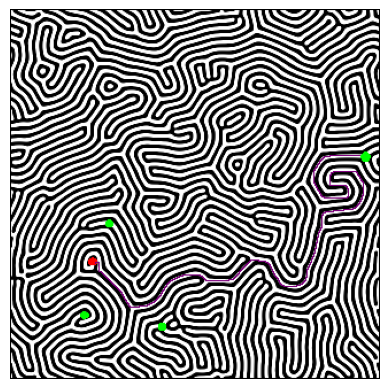

Camino encontrado por BFS hasta la meta (128, 305) : [(222, 74), (221, 74), (220, 74), (220, 75), (220, 76), (220, 77), (221, 77), (222, 77), (223, 77), (224, 77), (225, 77), (226, 77), (227, 77), (228, 77), (228, 78), (228, 79), (229, 79), (229, 80), (230, 80), (230, 81), (231, 81), (231, 82), (232, 82), (232, 83), (233, 83), (233, 84), (234, 84), (234, 85), (235, 85), (235, 86), (236, 86), (236, 87), (237, 87), (237, 88), (238, 88), (238, 89), (239, 89), (239, 90), (240, 90), (240, 91), (241, 91), (241, 92), (242, 92), (242, 93), (243, 93), (243, 94), (244, 94), (244, 95), (245, 95), (245, 96), (246, 96), (246, 97), (247, 97), (248, 97), (248, 98), (249, 98), (250, 98), (250, 99), (251, 99), (252, 99), (252, 100), (253, 100), (253, 101), (254, 101), (255, 101), (255, 102), (256, 102), (256, 103), (257, 103), (258, 103), (258, 104), (259, 104), (259, 105), (259, 106), (259, 107), (259, 108), (259, 109), (259, 110), (259, 111), (259, 112), (258, 112), (258, 113), (258, 114), (258, 115)

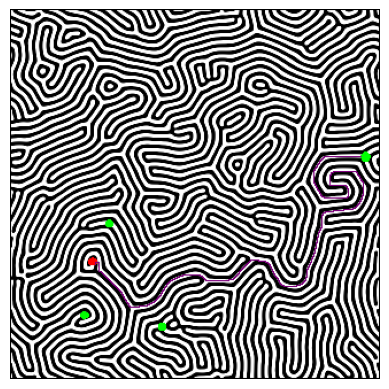

Camino encontrado por BFS hasta la meta (129, 305) : [(222, 74), (221, 74), (220, 74), (220, 75), (220, 76), (220, 77), (221, 77), (222, 77), (223, 77), (224, 77), (225, 77), (226, 77), (227, 77), (228, 77), (228, 78), (228, 79), (229, 79), (229, 80), (230, 80), (230, 81), (231, 81), (231, 82), (232, 82), (232, 83), (233, 83), (233, 84), (234, 84), (234, 85), (235, 85), (235, 86), (236, 86), (236, 87), (237, 87), (237, 88), (238, 88), (238, 89), (239, 89), (239, 90), (240, 90), (240, 91), (241, 91), (241, 92), (242, 92), (242, 93), (243, 93), (243, 94), (244, 94), (244, 95), (245, 95), (245, 96), (246, 96), (246, 97), (247, 97), (248, 97), (248, 98), (249, 98), (250, 98), (250, 99), (251, 99), (252, 99), (252, 100), (253, 100), (253, 101), (254, 101), (255, 101), (255, 102), (256, 102), (256, 103), (257, 103), (258, 103), (258, 104), (259, 104), (259, 105), (259, 106), (259, 107), (259, 108), (259, 109), (259, 110), (259, 111), (259, 112), (258, 112), (258, 113), (258, 114), (258, 115)

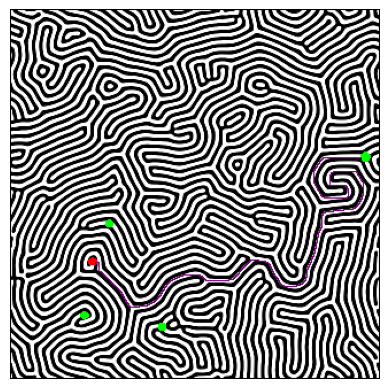

KeyError: (185, 83)

In [111]:
#Depth First Search
def mark_path_on_image(discretized_img, path, color):
    marked_img = np.copy(discretized_img)
    for position in path:
        row, column = position
        marked_img[row, column] = color
    return marked_img


# Definir colores para la primera gráfica
start_color = [255, 0, 0]  # Rojo
end_color = [0, 255, 0]  # Verde
first_guide_color = [126, 0, 126]  # Rojo para la primera guía

# Encontrar el camino para cada punto final y marcarlo en la imagen
for i, end_point in enumerate(end_points):
    path1 = bfs.search(start_point, end_point)
    print("Camino encontrado por BFS hasta la meta", end_point, ":", path1)
    
    if i == 0:  # Para la primera gráfica, marca el camino con el color rojo y las coordenadas con sus colores originales
        marked_img = mark_path_on_image(discretized_img, path1, first_guide_color)
        marked_img_with_start_path = mark_path_on_image(marked_img, [start_point], start_color)
        marked_img_with_start_path = mark_path_on_image(marked_img_with_start_path, [end_point], end_color)
    else:  # Para las siguientes gráficas, marca el camino con el color guía morado
        marked_img = mark_path_on_image(discretized_img, path1, first_guide_color)
        marked_img_with_start_path = mark_path_on_image(marked_img, path1, first_guide_color)

    # Guardar la imagen marcada
    plt.imshow(marked_img_with_start_path)
    plt.axis('off')
    plt.savefig(f'path_to_end_{i+1}.png', bbox_inches='tight')
    plt.show()

In [ ]:
#DFS

def plotWithPath(discretized_img, result_path):
    # Crear una copia de la imagen discretizada para no modificar la original
    img_with_path = np.copy(discretized_img)

    # Resaltar el camino en la copia de la imagen
    for point in result_path:
        y, x = point
        img_with_path[y, x, :] = [14, 25, 60]  # Resaltar el camino en rojo

    plt.imshow(img_with_path)
    plt.axis('off')
    plt.show()

# Crear una instancia de DFSAlgorithm y ejecutar la búsqueda
dfs_algorithm = DFSAlgorithm(discretized_matrix)

result_path = dfs_algorithm.search(start_point, end_points[1])

print("Camino encontrado:", result_path)

# Visualizar la imagen discretizada con el camino resultante
plotWithPath(discretized_img, result_path)

In [ ]:
#A* Algorithm empleando Manhattan Distance y 0
def plotting(heuristic, maze, path):
    maze_array = np.array(maze)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(maze_array, cmap='Greys', interpolation='nearest')
    start = path[0]
    goal = path[-1]
    ax.plot(start[1], start[0], "ro", markersize=10)  # Start rojo
    ax.plot(goal[1], goal[0], "gs", markersize=10)  # Goal verde

    for (y, x) in path:
        ax.plot(x, y, "bs", markersize=5)
    
    ax.axis('off')
    if heuristic == 1:
        ax.set_title('Maze with Manhattan Distance Heuristic Path')
    elif heuristic == 0:
        ax.set_title('Maze with 0 Heuristic Path')
    plt.show()

astar = AStarSearch(discretized_matrix)
# caminos usando heuristica Manhattan
path1 = astar.search(1, start_point, end_points)
print(path1)
plotting(1, discretized_matrix, path1)
path2 = astar.search(1, start_point, end_points)
print(path1)
plotting(1, discretized_matrix, path2)

# caminos usando heuristica 0
path1 = astar.search(0, start_point, end_points)
print(path1)
plotting(0, discretized_matrix, path1)
path2 = astar.search(0, start_point, end_points)
print(path1)
plotting(0, discretized_matrix, path2)
